In [1]:
!nvidia-smi

Wed Jan 15 19:29:32 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P0             28W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# 1. Download dataset

In [2]:
!pip install gdown torchinfo --quiet

In [3]:
import sys
sys.path.append('/content/Traffic-Vehicle-Detection-in-Normal-and-Adverse-Environmental-Conditions')

In [4]:
import requests
from pathlib import Path

if Path("dataloader.py").is_file():
  print("File dataloader.py exists")
else:
  request = requests.get(url="https://raw.githubusercontent.com/nguyenquan132/Traffic-Vehicle-Detection-in-Normal-and-Adverse-Environmental-Conditions/refs/heads/master/dataloader.py")
  with open("dataloader.py", 'wb') as f:
    f.write(request.content)

In [5]:
if Path("evaluate.py").is_file():
  print("File evaluate.py exists")
else:
  request = requests.get(url="https://raw.githubusercontent.com/nguyenquan132/Traffic-Vehicle-Detection-in-Normal-and-Adverse-Environmental-Conditions/refs/heads/master/evaluate.py")
  with open("evaluate.py", 'wb') as f:
    f.write(request.content)

In [6]:
if Path("function.py").is_file():
  print("File function.py exists")
else:
  request = requests.get(url="https://raw.githubusercontent.com/nguyenquan132/Traffic-Vehicle-Detection-in-Normal-and-Adverse-Environmental-Conditions/refs/heads/master/function.py")
  with open("function.py", 'wb') as f:
    f.write(request.content)

In [7]:
if Path("train.py").is_file():
  print("File train.py exists")
else:
  request = requests.get(url="https://raw.githubusercontent.com/nguyenquan132/Traffic-Vehicle-Detection-in-Normal-and-Adverse-Environmental-Conditions/refs/heads/master/faster_rcnn/train.py")
  with open("train.py", 'wb') as f:
    f.write(request.content)

# 2. Load dataset from dataloader.py

In [8]:
from dataloader import TrafficVehicle
import cv2
import matplotlib.pyplot as plt
import torch
from function import collate_fn, loss_mAP_curve, precision_recall_curve, confidence_metric
from torch.utils.data import DataLoader, SubsetRandomSampler
import albumentations as A
from evaluate import evaluate
from train import train_step
import numpy as np
from torchvision import models
from torch import nn
from albumentations.pytorch import ToTensorV2
from tqdm.auto import tqdm
from torchmetrics.detection.mean_ap import MeanAveragePrecision

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.0 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


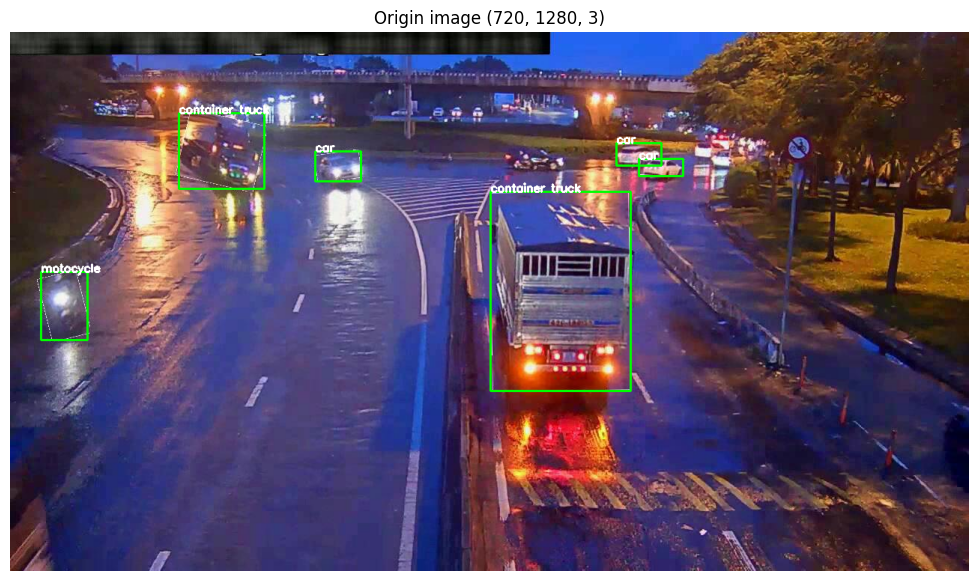

In [9]:
data = TrafficVehicle(folder="/kaggle/input/dataset-vehicle/data/data/train", transform_box_type="corner")
origin_image = data[5520][0]

plt.figure(figsize=(15, 7))
labels, boxes = data[5520][1]['labels'], torch.Tensor.numpy(data[5520][1]['boxes'])
frame = origin_image.copy()

for box, label in zip(boxes, labels):
    xmin, ymin, xmax, ymax = int(box[0]), int(box[1]), int(box[2]), int(box[3])
    annotated_image = cv2.rectangle(frame, (xmin, ymin), (xmax, ymax), color=(0, 255, 0), thickness=2)
    label_name = data.class_name[int(label)]
    annotated_image = cv2.putText(annotated_image, label_name, (xmin, ymin), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.5,
                                color=(255, 255, 255), thickness=2)

plt.imshow(annotated_image)
plt.title(f"Origin image {origin_image.shape}")
plt.axis('off')
plt.show()

In [10]:
train_transform = A.Compose([
    A.Resize(300, 300),
    A.GaussianBlur(blur_limit=(3, 7), p=0.5),
    A.RandomBrightnessContrast(brightness_limit=(-0.3, -0.3), contrast_limit=(0.2, 0.2), p=0.5),
    A.HueSaturationValue(hue_shift_limit=(1, 1), p=0.5),
    A.Sharpen(p=0.5),
    A.ToFloat(max_value=255.0),
    ToTensorV2(p=1.0)
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels'], min_visibility=0.3))

val_transform = A.Compose([
    A.Resize(300, 300),
    A.ToFloat(max_value=255.0),
    ToTensorV2(p=1.0)
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

train_data = TrafficVehicle(folder="/kaggle/input/dataset-vehicle/data/data/train", transforms=train_transform, 
                            transform_box_type="corner")
val_data = TrafficVehicle(folder="/kaggle/input/dataset-vehicle/data/data/val", transforms=val_transform, 
                          transform_box_type="corner")

Image after applying data augmentation



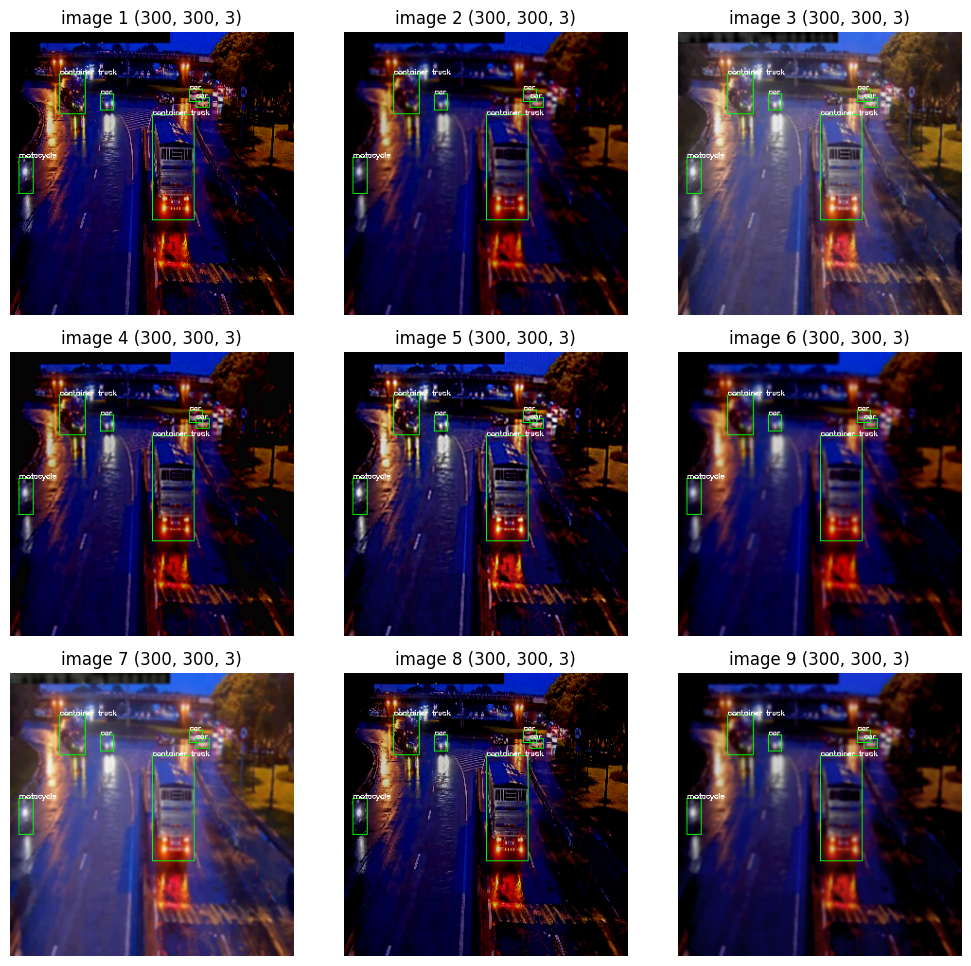

In [11]:
print("Image after applying data augmentation\n")
plt.figure(figsize=(10, 10))
for i in range(1, 10):
    img = torch.Tensor.numpy(train_data[5520][0].permute(1, 2, 0))

    height, width = origin_image.shape[:2]
    labels, boxes = train_data[5520][1]['labels'], torch.Tensor.numpy(train_data[5520][1]['boxes'])
    frame = img.copy()

    for box, label in zip(boxes, labels):
        xmin, ymin, xmax, ymax = int(box[0]), int(box[1]), int(box[2]), int(box[3])
        annotated_img = cv2.rectangle(frame, (xmin, ymin), (xmax, ymax), color=(0, 255, 0), thickness=1)
        label_name = train_data.class_name[int(label)]
        annotated_img = cv2.putText(annotated_img, label_name, (xmin, ymin), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.25,
                                    color=(255, 255, 255), thickness=1)

    plt.subplot(3, 3, i)
    plt.imshow(annotated_img)
    plt.title(f"image {i} {img.shape}")
    plt.tight_layout()
    plt.axis('off')

plt.show()

In [12]:
class_name = train_data.class_name
class_name

{1: 'motocycle', 2: 'car', 3: 'coach', 4: 'container truck'}

# 3. Prepare dataloader

In [13]:
print(f"Size of train_data: {len(train_data)}")
print(f"Size of val_data: {len(val_data)}")

Size of train_data: 9452
Size of val_data: 2067


In [14]:
torch.manual_seed(42)
# Load DataLoader
train_dataloader = DataLoader(dataset=train_data, batch_size=8, shuffle=True, num_workers=1, collate_fn=collate_fn)
val_dataloader = DataLoader(dataset=val_data, batch_size=8, shuffle=True, num_workers=1, collate_fn=collate_fn)

# 4. Finetuning model

In [15]:
import torch
import torchvision
from torchvision.models.detection.backbone_utils import BackboneWithFPN
from torchvision.models.detection import FasterRCNN

# Load pretrained 
weights = torchvision.models.MobileNet_V3_Large_Weights.DEFAULT
mobilenet = torchvision.models.mobilenet_v3_large(weights=weights)

# Xác định returned layers
return_layers = {'3': '0', '6': '1',  '12': '2',  '15': '3'}

# Tạo backbone với FPN
backbone = BackboneWithFPN(
    mobilenet.features,
    return_layers=return_layers,
    in_channels_list=[24, 40, 112, 160],
    out_channels=256
)

# Khởi tạo FasterRCNN
num_classes = 5
model = FasterRCNN(backbone, 
                   num_classes=num_classes)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-5c1a4163.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-5c1a4163.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 158MB/s]


In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.load_state_dict(torch.load("/kaggle/input/models/pytorch/default/1/model_backbone_mobilenetv3.pth",
                                 weights_only=True))

<All keys matched successfully>

In [17]:
# Model Zero-DCE
import torch
import torch.nn as nn
import torch.nn.functional as F

class ZeroDCE(nn.Module):
    def __init__(self):
        super(ZeroDCE, self).__init__()
        self.iterations = 4
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3),
                               stride=1, padding=1, bias=True)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3),
                               stride=1, padding=1, bias=True)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3),
                               stride=1, padding=1, bias=True)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3),
                               stride=1, padding=1, bias=True)
        self.conv5 = nn.Conv2d(in_channels=32*2, out_channels=32, kernel_size=(3, 3),
                               stride=1, padding=1, bias=True)
        self.conv6 = nn.Conv2d(in_channels=32*2, out_channels=32, kernel_size=(3, 3),
                               stride=1, padding=1, bias=True)
        self.conv7 = nn.Conv2d(in_channels=32*2, out_channels=24, kernel_size=(3, 3),
                              stride=1, padding=1, bias=True)
        
        self.relu = nn.ReLU(inplace=True)
  
    def forward(self, x):
        x1 = self.relu(self.conv1(x))
        x2 = self.relu(self.conv2(x1))
        x3 = self.relu(self.conv3(x2))
        x4 = self.relu(self.conv4(x3))
        # Skip connection
        x5 = self.relu(self.conv5(torch.cat([x3, x4], dim=1)))
        x6 = self.relu(self.conv6(torch.cat([x2, x5], dim=1)))
        x_r = F.tanh(self.conv7(torch.cat([x1, x6], dim=1)))
        
        
        # Chia thành 8 curve parameters cho mỗi kênh màu RGB 
        r1, r2, r3, r4, r5, r6, r7, r8 = torch.split(x_r, 3, dim=1)
        x = x + r1*(torch.pow(x, 2) - x)
        x = x + r2*(torch.pow(x, 2) - x)
        x = x + r3*(torch.pow(x, 2) - x)
        enhance_image_1 = x + r4*(torch.pow(x, 2) - x)
        x = enhance_image_1 + r5*(torch.pow(enhance_image_1, 2) - enhance_image_1)
        x = x + r6*(torch.pow(x, 2) - x)
        x = x + r7* (torch.pow(x, 2) - x)
        enhance_image = x + r8*(torch.pow(x, 2) - x)
        r = torch.cat([r1, r2, r3, r4, r5, r6, r7, r8], dim=1)

        return enhance_image_1, enhance_image, r

In [18]:
# Download model Zero-DCE
import requests
from pathlib import Path

if Path("8LE-color-loss2_best_model.pth").is_file():
    print("file đã tồn tại")
else:
    request = requests.get(url="https://github.com/bsun0802/Zero-DCE/raw/refs/heads/master/train-jobs/ckpt/8LE-color-loss2_best_model.pth")
    with open("8LE-color-loss2_best_model.pth", "wb") as f:
        f.write(request.content)

In [19]:
model_dce = ZeroDCE()
model_dce.load_state_dict(torch.load("/kaggle/working/8LE-color-loss2_best_model.pth", 
                                 weights_only=False,
                                 map_location='cuda:0')['model'])
model_dce = model_dce.to(device)

# 5. Evaluation

In [20]:
def iou(boxes1, boxes2):
    """
    Tính IoU giữa tất cả các cặp boxes từ boxes1 và boxes2
    Args:
        boxes1 (torch.Tensor): shape (N, 4) - N boxes với format (x1, y1, x2, y2)
        boxes2 (torch.Tensor): shape (M, 4) - M boxes với format (x1, y1, x2, y2)
    Returns:
        torch.Tensor: shape (N, M) - ma trận IoU
    """
    # Tính area của boxes1
    area1 = (boxes1[:, 2] - boxes1[:, 0]) * (boxes1[:, 3] - boxes1[:, 1])  # shape: (N,)
    
    # Tính area của boxes2
    area2 = (boxes2[:, 2] - boxes2[:, 0]) * (boxes2[:, 3] - boxes2[:, 1])  # shape: (M,)
    
    # Mở rộng kích thước để broadcast
    # boxes1: (N, 1, 4), boxes2: (1, M, 4)
    boxes1 = boxes1[:, None, :]  # Thêm chiều mới ở giữa
    boxes2 = boxes2[None, :, :]  # Thêm chiều mới ở đầu
    
    # Tính tọa độ của phần giao nhau
    left_top = torch.maximum(boxes1[..., :2], boxes2[..., :2])  # shape: (N, M, 2)
    right_bottom = torch.minimum(boxes1[..., 2:], boxes2[..., 2:])  # shape: (N, M, 2)
    
    # Tính width và height của phần giao nhau
    wh = (right_bottom - left_top).clamp(min=0)  # shape: (N, M, 2)
    inter = wh[..., 0] * wh[..., 1]  # shape: (N, M)
    
    # Tính union
    union = area1[:, None] + area2[None, :] - inter
    
    # Tính IoU
    iou = inter / union.clamp(min=1e-6)
    
    return iou

In [21]:
from torchmetrics.detection import MeanAveragePrecision
from tqdm import tqdm
import torch

def validate(val_dataloader, model, num_class, iou_threshold, device):
    model = model.to(device)
    model.eval()
    
    # Khởi tạo các biến để tính precision và recall
    true_positives = 0
    false_positives = 0
    false_negatives = 0
    
    # Khởi tạo metric MAP
    metric = MeanAveragePrecision(
        iou_type="bbox",
        iou_thresholds=[iou_threshold],
        box_format="xyxy",
        class_metrics=True
    ).to(device)
    
    with torch.inference_mode():
        for batch, (images, targets) in tqdm(enumerate(val_dataloader), total=len(val_dataloader)):
            images = [image.to(device) for image in images]
            enhanced_images = []
            for image in images:
                _, enhance_image, _ = model_dce(image.unsqueeze(0))
                enhanced_images.append(enhance_image.squeeze())
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
            outputs = model(enhanced_images)
            
            preds = [{
                "boxes": output["boxes"],
                "scores": output["scores"],
                "labels": output["labels"],
            } for output in outputs]
            
            gt = [{
                "boxes": target["boxes"],
                "labels": target["labels"],
            } for target in targets]
            
            metric.update(preds, gt)
            
            for pred, target in zip(preds, gt):
                pred_boxes = pred["boxes"]
                pred_scores = pred["scores"]
                pred_labels = pred["labels"]
                gt_boxes = target["boxes"]
                gt_labels = target["labels"]
                
                ious = iou(pred_boxes, gt_boxes)
                
                # Chuyển IoU thành mask bool và sau đó thành float để có thể dùng argmax
                matches = (ious > iou_threshold).float()
                
                for pred_idx in range(len(pred_boxes)):
                    if pred_scores[pred_idx] > 0.5:
                        if matches[pred_idx].any():
                            # Tìm gt_idx có IoU cao nhất với pred_idx
                            gt_idx = matches[pred_idx].argmax()
                            if pred_labels[pred_idx] == gt_labels[gt_idx]:
                                true_positives += 1
                            else:
                                false_positives += 1
                        else:
                            false_positives += 1
                
                # Đếm false negatives
                matched_gt = matches.sum(dim=0) > 0  # Chuyển về bool
                false_negatives += (~matched_gt).sum().item()
    
    # Tính toán kết quả MAP
    result = metric.compute()
    mAP50 = result["map_50"].item()
    mAP50_95 = result["map"].item()
    
    # Tính precision và recall
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    
    # Tính F1-score
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    return mAP50, mAP50_95, f1_score

In [22]:
mAP50, mAP50_95, f1_score = validate(val_dataloader=val_dataloader,
                                     model=model,
                                     num_class=num_classes-1,
                                     iou_threshold=0.5,
                                     device=device)
print(f"mAP@50: {mAP50:.4f}")
print(f"mAP@50-95: {mAP50_95:.4f}")
print(f"F1-score: {f1_score:.4f}")

100%|██████████| 259/259 [01:16<00:00,  3.39it/s]


mAP@50: 0.6715
mAP@50-95: 0.6715
F1-score: 0.6968
